In [1]:
import pandas as pd

# Load the Excel file (dataset)
file_path = 'data/task1-dataset-1723704917.xlsx'
xls = pd.ExcelFile(file_path)

# List the sheet names to understand the structure of the file
sheet_names = xls.sheet_names
sheet_names


['orders_detailed', 'complaint_types']

## Dataset file explanations 
- order_id: primary key for the table and unique id for each order
- order_time: day and time of the order (GMT+3)
- order_city: province field of the delivery address
- order_area: district field of the delivery address
- order_kitchen: pre-defined kitchen group types for the order (i.e. Pizza)
- order_restaurant_id: unique id of the restaurant
- order_size_TRY: Amount of the order in Turkish Lira
- preffered_payment_method: Preferred payment method chosen by user, can be Cash, Online Payment, Credit/Debit Card, Meal Card
- isSeamless: If an order is seamless order, this field is 1, else 0. Boolean.
- isnotSeamless: If an order is not a seamless order, this field is 1, else 0. Boolean.
- contact_reason_CSRLevel3: A list of pre-defined complaints, types and detailes are provided in the Excel in different sheet.
- contact_reason_MainGroup: CSR Level 3 complaints are grouped a higher complaint breakdown.
- isContact: If a user contacted via live operator is 1, else 0. Boolean.
- isSelfService: If a user is not seamless and not contacted via live operator, meaning Self -Service is used and value is 1, else 0. Boolean.
- ContactCSAT: 1-5 scale points given by the user after Contact
- SelfServiceCSAT: 1-5 scale points given by the user after Self-Service
- NPS-Q-Score: 1-10 scale points given by the user about recommending Yemeksepeti to others. Used to calculate NPS.


## The plan to solve this task
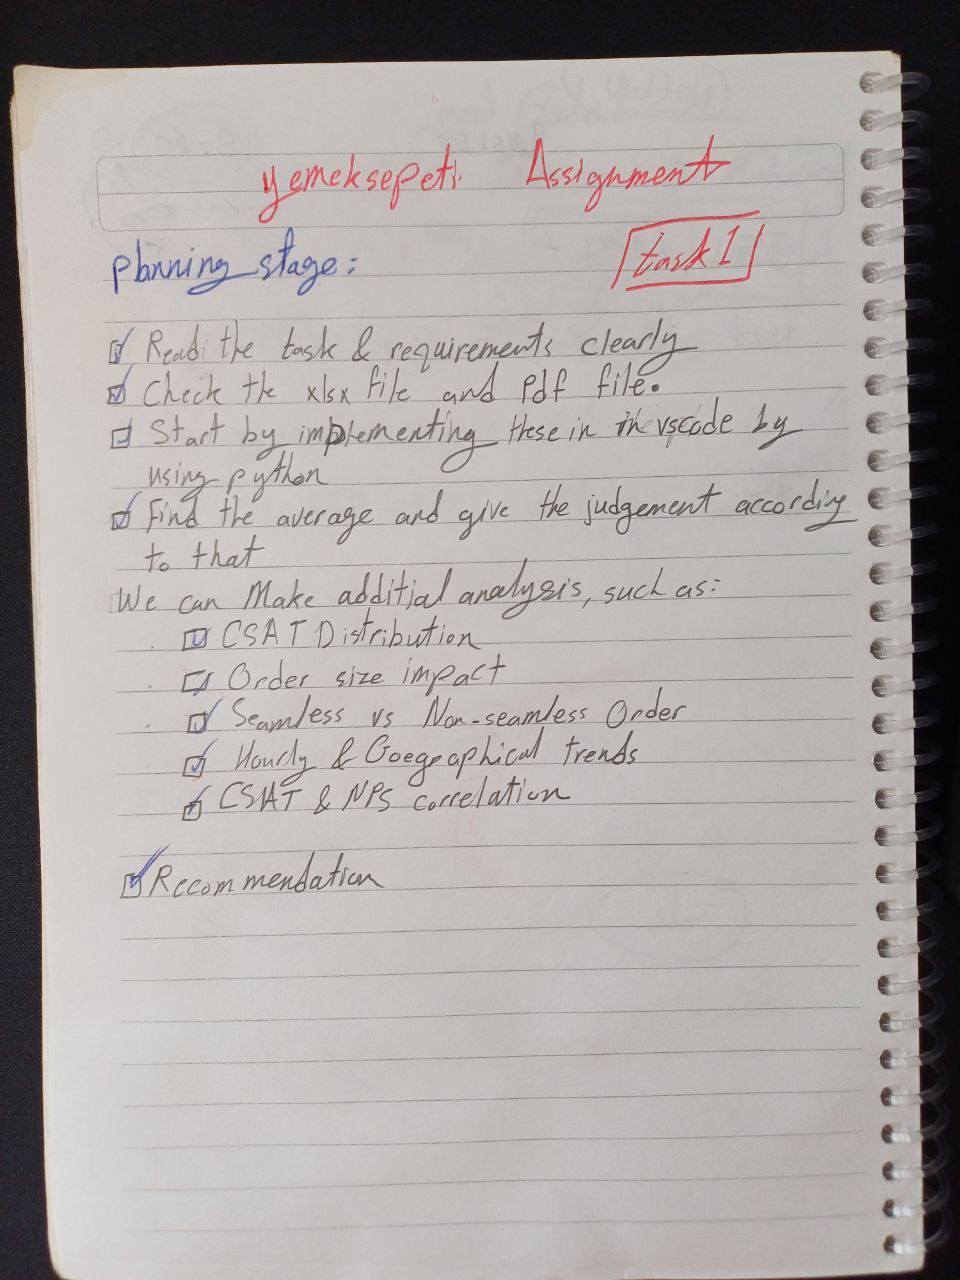

In [2]:
# Load the orders_detailed sheet
orders_df = pd.read_excel(xls, sheet_name='orders_detailed')

# Show the first few rows of the dataset to understand its structure
orders_df.head()


,order_id,order_time,order_city,order_area,order_kitchen,order_restaurant_id,order_size_TRY,preffered_payment_method,isSeamless,isnotSeamless,contact_reason_CSRLevel3,contact_reason_MainGroup,isContact,isSelfService,ContactCSAT,SelfServiceCSAT,NPS-Q-Score
0,9450303,2024-07-26 01:26:02,İstanbul,Sancaktepe,Kahvaltı,723542,103,Online Payment,1,0,-,-,0,0,0,0,8
1,3091190,2024-02-24 13:44:21,İstanbul,Şile,Pizza,207622,80,Cash,1,0,-,-,0,0,0,0,4
2,8040029,2024-01-06 19:26:41,İstanbul,Beykoz,Pide,35740,168,Cash,1,0,-,-,0,0,0,0,10
3,9828010,2024-08-23 16:32:36,İstanbul,Bakırköy,Burger,614173,104,Credit/Debit Card,1,0,-,-,0,0,0,0,8
4,7887475,2024-07-19 09:23:03,İstanbul,Büyükçekmece,Burger,818521,415,Online Payment,1,0,-,-,0,0,0,0,10


In [3]:
# Calculate key metrics for both Self-Service and Contact channels

# Filter Self-Service and Contact datasets
self_service_data = orders_df[orders_df['isSelfService'] == 1]
contact_data = orders_df[orders_df['isContact'] == 1]

# Key metrics
summary_metrics = {
    'Metric': ['Avg SelfServiceCSAT', 'Avg ContactCSAT', 'Avg NPS-Q-Score (Self-Service)', 
                'Avg NPS-Q-Score (Contact)', 'Self-Service Rate', 'Contact Rate'],
    'Self-Service': [
        self_service_data['SelfServiceCSAT'].mean(),
        None,
        self_service_data['NPS-Q-Score'].mean(),
        None,
        len(self_service_data) / len(orders_df),
        None
    ],
    'Contact': [
        None,
        contact_data['ContactCSAT'].mean(),
        None,
        contact_data['NPS-Q-Score'].mean(),
        None,
        len(contact_data) / len(orders_df)
    ]
}

summary_df = pd.DataFrame(summary_metrics)

# Display the DataFrame
print("CX Channel Metrics Summary:")
print(summary_df)

CX Channel Metrics Summary:
                           Metric  Self-Service   Contact
0             Avg SelfServiceCSAT      2.777320       NaN
1                 Avg ContactCSAT           NaN  2.726547
2  Avg NPS-Q-Score (Self-Service)      6.842415       NaN
3       Avg NPS-Q-Score (Contact)           NaN  7.035928
4               Self-Service Rate      0.203700       NaN
5                    Contact Rate           NaN  0.050100


# Further key insight over the analysis

### 1. Distribution of CSAT Scores (Self-Service and Contact)

In [4]:
# 1. Distribution of CSAT Scores (Self-Service and Contact)
csat_self_service_dist = self_service_data['SelfServiceCSAT'].value_counts().sort_index()
csat_contact_dist = contact_data['ContactCSAT'].value_counts().sort_index()

csat_cores = {
'CSAT Distribution (Self-Service)': csat_self_service_dist,
'CSAT Distribution (Contact)': csat_contact_dist,
}
csat_cores

{'CSAT Distribution (Self-Service)': SelfServiceCSAT
 1    1813
 2    3552
 3    1550
 4    1630
 5    1640
 Name: count, dtype: int64,
 'CSAT Distribution (Contact)': ContactCSAT
 1    534
 2    548
 3    814
 4    287
 5    322
 Name: count, dtype: int64}

### 2. Order Size and Payment Method Impact

In [5]:
# 2. Order Size and Payment Method Impact
order_size_impact_self_service = self_service_data.groupby('order_size_TRY').agg({
    'SelfServiceCSAT': 'mean',
    'order_size_TRY': 'size'
}).rename(columns={'order_size_TRY': 'order_count'})

order_size_impact_contact = contact_data.groupby('order_size_TRY').agg({
    'ContactCSAT': 'mean',
    'order_size_TRY': 'size'
}).rename(columns={'order_size_TRY': 'order_count'})

payment_method_impact_self_service = self_service_data.groupby('preffered_payment_method').agg({
    'SelfServiceCSAT': 'mean',
    'order_id': 'count'
}).rename(columns={'order_id': 'order_count'})

payment_method_impact_contact = contact_data.groupby('preffered_payment_method').agg({
    'ContactCSAT': 'mean',
    'order_id': 'count'
}).rename(columns={'order_id': 'order_count'})

order_size_and_payment_method = {   
    'Order Size Impact (Self-Service)': order_size_impact_self_service,
    'Order Size Impact (Contact)': order_size_impact_contact,
    'Payment Method Impact (Self-Service)': payment_method_impact_self_service,
    'Payment Method Impact (Contact)': payment_method_impact_contact,
}
order_size_and_payment_method

{'Order Size Impact (Self-Service)':                 SelfServiceCSAT  order_count
 order_size_TRY                              
 80                     2.753494          787
 81                     3.285714            7
 82                     2.833333           18
 83                     1.842105           19
 84                     3.214286           14
 ...                         ...          ...
 698                    2.722222           18
 699                    2.937500           16
 700                    3.111111            9
 701                    2.666667           15
 702                    2.666667           15
 
 [623 rows x 2 columns],
 'Order Size Impact (Contact)':                 ContactCSAT  order_count
 order_size_TRY                          
 80                 2.702703          185
 81                 2.000000            2
 82                 2.500000            4
 83                 2.333333            3
 84                 3.000000            1
 ...          

### 3. Seamless vs. Non-Seamless Orders

In [6]:
# 3. Seamless vs. Non-Seamless Orders
seamless_impact_self_service = self_service_data.groupby('isSeamless').agg({
    'SelfServiceCSAT': 'mean',
    'order_id': 'count'
}).rename(columns={'order_id': 'order_count'})

seamless_impact_contact = contact_data.groupby('isSeamless').agg({
    'ContactCSAT': 'mean',
    'order_id': 'count'
}).rename(columns={'order_id': 'order_count'})

seamless_and_non_seamless = {
	'Seamless Order Impact (Self-Service)': seamless_impact_self_service,
    'Seamless Order Impact (Contact)': seamless_impact_contact,
}
seamless_and_non_seamless

{'Seamless Order Impact (Self-Service)':             SelfServiceCSAT  order_count
 isSeamless                              
 0                   2.77732        10185,
 'Seamless Order Impact (Contact)':             ContactCSAT  order_count
 isSeamless                          
 0              2.726547         2505}

### 4. Geographical and Time-Based Trends

In [7]:
# 4. Geographical and Time-Based Trends
self_service_data['order_hour'] = pd.to_datetime(self_service_data['order_time']).dt.hour
contact_data['order_hour'] = pd.to_datetime(contact_data['order_time']).dt.hour

hourly_impact_self_service = self_service_data.groupby('order_hour').agg({
    'SelfServiceCSAT': 'mean',
    'order_id': 'count'
}).rename(columns={'order_id': 'order_count'})

hourly_impact_contact = contact_data.groupby('order_hour').agg({
    'ContactCSAT': 'mean',
    'order_id': 'count'
}).rename(columns={'order_id': 'order_count'})

geo_impact_self_service = self_service_data.groupby('order_city').agg({
    'SelfServiceCSAT': 'mean',
    'order_id': 'count'
}).rename(columns={'order_id': 'order_count'})

geo_impact_contact = contact_data.groupby('order_city').agg({
    'ContactCSAT': 'mean',
    'order_id': 'count'
}).rename(columns={'order_id': 'order_count'})

geographical_and_time_based = {
    'Hourly Impact (Self-Service)': hourly_impact_self_service,
    'Hourly Impact (Contact)': hourly_impact_contact,
    'Geographical Impact (Self-Service)': geo_impact_self_service,
    'Geographical Impact (Contact)': geo_impact_contact,
}
geographical_and_time_based

/var/folders/v6/h7vdyxld5t9c3vy6l67q9c2m0000gn/T/ipykernel_10826/1055488342.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self_service_data['order_hour'] = pd.to_datetime(self_service_data['order_time']).dt.hour
/var/folders/v6/h7vdyxld5t9c3vy6l67q9c2m0000gn/T/ipykernel_10826/1055488342.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  contact_data['order_hour'] = pd.to_datetime(contact_data['order_time']).dt.hour


{'Hourly Impact (Self-Service)':             SelfServiceCSAT  order_count
 order_hour                              
 0                  2.828358          402
 1                  2.757437          437
 2                  2.689904          416
 3                  2.796069          407
 4                  2.860092          436
 5                  2.782506          423
 6                  2.771971          421
 7                  2.821192          453
 8                  2.950673          446
 9                  2.920482          415
 10                 2.832168          429
 11                 2.708235          425
 12                 2.745192          416
 13                 2.701389          432
 14                 2.789838          433
 15                 2.718204          401
 16                 2.626263          396
 17                 2.803874          413
 18                 2.612472          449
 19                 2.801339          448
 20                 2.819820          444
 2

### 5. Correlation between Self-Service CSAT and NPS

In [8]:
# 5. Correlation between Self-Service CSAT and NPS
csat_nps_correlation_self_service = self_service_data[['SelfServiceCSAT', 'NPS-Q-Score']].corr().iloc[0,1]
csat_nps_correlation_contact = contact_data[['ContactCSAT', 'NPS-Q-Score']].corr().iloc[0,1]

self_service_csat_and_nps = {
	'Self-Service CSAT and NPS Correlation': csat_nps_correlation_self_service,
    'Contact CSAT and NPS Correlation': csat_nps_correlation_contact
}
self_service_csat_and_nps

{'Self-Service CSAT and NPS Correlation': np.float64(0.12756445848804748),
 'Contact CSAT and NPS Correlation': np.float64(-0.019151231915610033)}